# Applied Data Science Capstone Final Project

Import necessary packages and dependencies:

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          92 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.21.0-py_0



geopy-1.21.0         | 58 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Lib

Access dataset from server containing coordinate data for 5 boroughs of New York City. Data originally accessed from https://geo.nyu.edu/catalog/nyu_2451_34572

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


Load data downloaded in previous cell

In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Define variable that incorporates data from the 'features' key in the downloaded dataset

In [4]:
neighborhoods_data = newyork_data['features']

Examine the first listed item

In [5]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

Create a Pandas dataframe using data from neighborhoods_data

In [6]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [7]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


In [8]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Examine the first 5 rows of the new data frame

In [9]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Slice data from neighborhoods data frame and create new data frame with neighborhood data exclusively from the borough of Manhattan

In [10]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


Obtain coordinates for Manhattan

In [11]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geographical coordinate of Manhattan are 40.7896239, -73.9598939.


Create map of Manhattan with neighborhoods superimposed

In [12]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

Define necessary credential and version to access Foursquare API

In [13]:
CLIENT_ID = '1JJQFOB3GGM1NSMQOBTPQJESSJXRCY11IKBSFCY3D13YXRZT' # your Foursquare ID
CLIENT_SECRET = '4NGQYGY0UUGPYSEMN2DZXHODDZUCJLCDYNNK1XWHSJTIEHJL' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 1JJQFOB3GGM1NSMQOBTPQJESSJXRCY11IKBSFCY3D13YXRZT
CLIENT_SECRET:4NGQYGY0UUGPYSEMN2DZXHODDZUCJLCDYNNK1XWHSJTIEHJL


Define get_category_type in order to obtain category associated with a given venue

In [14]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Clean json file and use get_category_type to create a new Pandas dataframe with venue name, category, and coordinates. This data pertains to all neighborhoods in Manhattan

In [15]:
LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Create manhattan_venues dataframe using the getNearbyVenues function

In [16]:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


Use one hot encoding to generate integer values for the categorical 'Venue Category' data. Examine the first 5 rows in the new manhattan_onehot dataframe

In [17]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Duty-free Shop,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Snack Place,Soccer Field,Social Club,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy

Create a new dataframe filtering out all venue categories except those that are pet-related

In [18]:
manhattan_onehot_filtered = manhattan_onehot[['Neighborhood','Dog Run', 'Pet Café', 'Pet Service', 'Pet Store', 'Veterinarian']]
manhattan_onehot_filtered = manhattan_onehot_filtered.groupby(['Neighborhood']).sum()
manhattan_onehot_filtered

,Dog Run,Pet Café,Pet Service,Pet Store,Veterinarian
Neighborhood,,,,,
Battery Park City,0,0,0,1,0
Carnegie Hill,0,0,0,1,0
Central Harlem,0,0,0,0,0
Chelsea,0,0,0,1,0
Chinatown,0,0,0,0,0
Civic Center,0,0,0,0,0
Clinton,1,0,0,0,0
East Harlem,0,0,0,0,0
East Village,1,1,0,0,0


Create new dataframe which removes Manhattan neighborhoods that have no reported pet-related venues

In [19]:
manhattan_pets = manhattan_onehot_filtered.loc[(manhattan_onehot_filtered!=0).any(axis=1)]
manhattan_pets

,Dog Run,Pet Café,Pet Service,Pet Store,Veterinarian
Neighborhood,,,,,
Battery Park City,0,0,0,1,0
Carnegie Hill,0,0,0,1,0
Chelsea,0,0,0,1,0
Clinton,1,0,0,0,0
East Village,1,1,0,0,0
Financial District,1,0,0,0,0
Flatiron,0,0,0,2,0
Greenwich Village,1,0,0,0,0
Hudson Yards,2,0,0,0,0


Add a 'Totals' Column to the manhattan_pets dataframe that contains the sum value all of pet-related venues for a given neighborhood

In [20]:
manhattan_pets['Totals'] = manhattan_pets.sum(numeric_only=True, axis=1)
manhattan_pets

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Dog Run,Pet Café,Pet Service,Pet Store,Veterinarian,Totals
Neighborhood,,,,,,
Battery Park City,0,0,0,1,0,1
Carnegie Hill,0,0,0,1,0,1
Chelsea,0,0,0,1,0,1
Clinton,1,0,0,0,0,1
East Village,1,1,0,0,0,2
Financial District,1,0,0,0,0,1
Flatiron,0,0,0,2,0,2
Greenwich Village,1,0,0,0,0,1
Hudson Yards,2,0,0,0,0,2


Create a new dataframe that sorts the Manahattan neighborhoods based on total sum of all pet-related venues

In [21]:
manhattan_pets_sorted = manhattan_pets.sort_values(by=['Totals'], ascending=True)
manhattan_pets_sorted

,Dog Run,Pet Café,Pet Service,Pet Store,Veterinarian,Totals
Neighborhood,,,,,,
Battery Park City,0,0,0,1,0,1
Upper West Side,1,0,0,0,0,1
Upper East Side,0,0,0,1,0,1
Tribeca,1,0,0,0,0,1
Stuyvesant Town,0,0,1,0,0,1
Noho,0,0,0,1,0,1
Murray Hill,0,0,1,0,0,1
Manhattan Valley,1,0,0,0,0,1
Lower East Side,0,1,0,0,0,1


Create a horizontal bar graph using Matplotlib visualizing total sum of pet-related venues in selected Manhattan neighborhoods

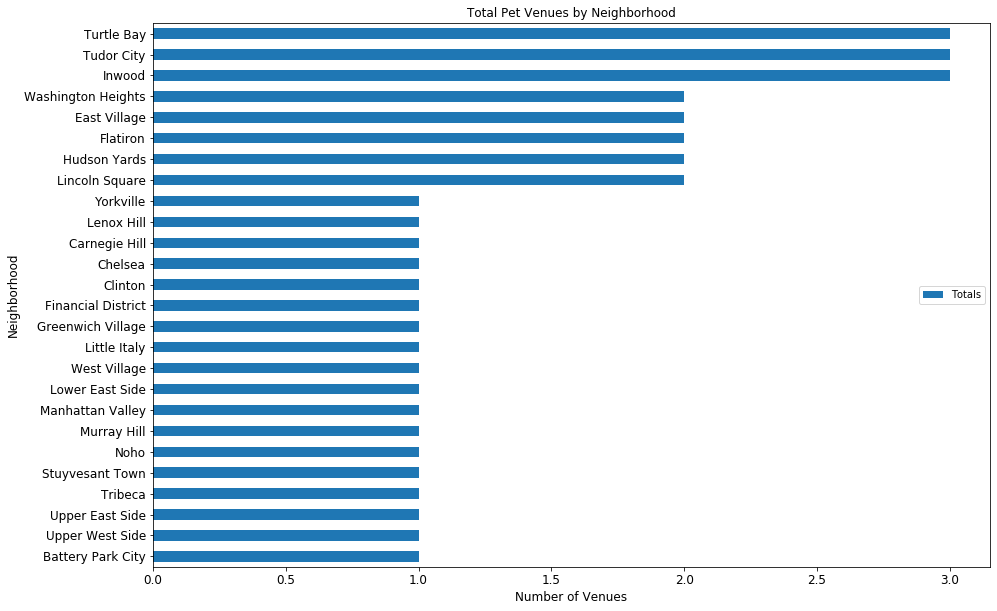

In [22]:
import matplotlib.pyplot as plt
ax = manhattan_pets_sorted[['Totals']].plot(kind='barh', title='Total Pet Venues by Neighborhood', figsize=(15,10), legend=True, fontsize=12)
ax.set_xlabel('Number of Venues',fontsize=12)
ax.set_ylabel('Neighborhood',fontsize=12)
ax.legend(loc="center right")

Create a horizontal bar graph visualizing different pet-related venues in selected Manhattan neighborhoods

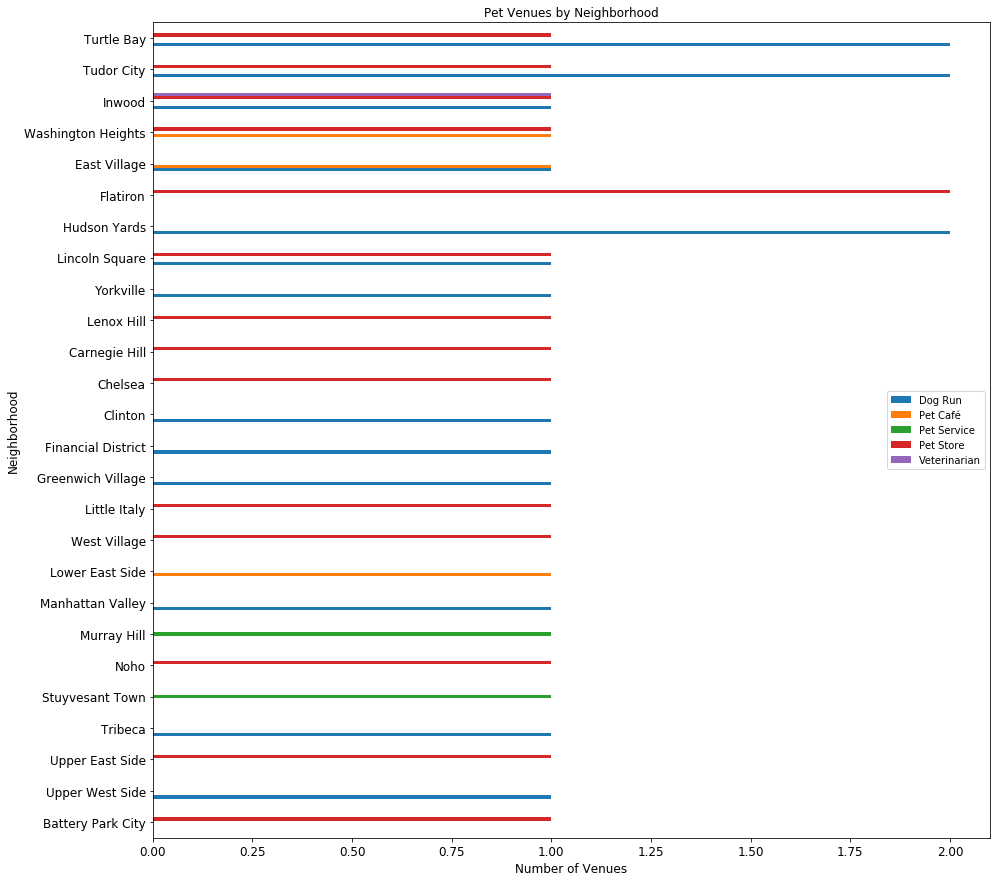

In [23]:
ax = manhattan_pets_sorted[['Dog Run', 'Pet Café', 'Pet Service', 'Pet Store', 'Veterinarian']].plot(kind='barh', title='Pet Venues by Neighborhood', figsize=(15,15), legend=True, fontsize=12)
ax.set_xlabel('Number of Venues',fontsize=12)
ax.set_ylabel('Neighborhood',fontsize=12)
ax.legend(loc="center right")